# Wave Spectra Datamesh Demo

Analyse spectra from Oceanum New Zealand wave hindcast using the Oceanum [Datamesh](https://oceanum-python.readthedocs.io/en/latest/index.html) and [wavespectra](https://github.com/wavespectra/wavespectra) python libraries

This notebook requires the following python libraries:

- oceanum
- wavespectra
- matplotlib
- cartopy

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import wavespectra

from oceanum.datamesh import Connector

import warnings
warnings.filterwarnings("ignore")

## Datamesh connector

Put your datamesh token in the Jupyterlab settings, or as the `token` argument in the constructor below

In [2]:
datamesh = Connector()

Using datamesh API version 0
You are using version 1.0.7 of oceanum_python which is the latest version available.


## Hindcast spectra data

### Search for datasource

Search for the Oceanum New Zealand 5km wave hindcast data in Datamesh using the [get_catalog](https://oceanum-python.readthedocs.io/en/latest/classes/datamesh/oceanum.datamesh.Connector.html#oceanum.datamesh.Connector.get_catalog) method which returns a catalog with all datasources matching the searching criteria

In [3]:
cat = datamesh.get_catalog("new zealand era5 wave 5km")
list(cat)

[
         Oceanum New Zealand 5 km ERA5 wave hindcast spectra [oceanum_wave_nz5km_era5_spec]
             Extent: (165.1999969482422, -47.900001525878906, 180.0, -34.0)
             Timerange: 1979-02-01 00:00:00+00:00 to 2024-08-01 00:00:00+00:00
         ,
 
         Oceanum New Zealand ERA5 multiscale wave parameters hindcast [oceanum_wave_nz1km_multiscale_era5_param]
             Extent: (165.0, -48.0, 180.0, -34.0)
             Timerange: 1979-02-01 00:00:00+00:00 to 2024-08-01 00:00:00+00:00
         ,
 
         gridded wave stats oceanum New Zealand 5km [oceanum_wave_nz_era5_v1_gridstats]
             Extent: (165.0, -48.0, 180.0, -34.0)
             Timerange: 1970-01-01 00:00:00+00:00 to 2024-11-06 04:26:14.157000+00:00
         ,
 
         Oceanum New Zealand ERA5 wave hindcast parameters [oceanum_wave_nz_era5_v1_grid]
             Extent: (165.0, -48.0, 180.0, -34.0)
             Timerange: 1979-02-01 00:00:00+00:00 to 2025-05-01 00:00:00+00:00
         ,
 
         Ocean

Each entry in the catalog is a Datamesh [Datasource](https://oceanum-python.readthedocs.io/en/latest/classes/datamesh/oceanum.datamesh.Datasource.html#oceanum.datamesh.Datasource) object which holds a number of attributes defining the data such as `variables`, `coordinates`, `schema`, `tstart`, `tend` and others. Datasource instances can also be directly created from the datasource ID using the `get_datasource` method:

In [4]:
ds = datamesh.get_datasource("oceanum_wave_nz_era5_v1_spec")

print(ds)
print(ds.description)
print(ds.tstart)
print(ds.tend)
print(ds.variables.keys())


        Oceanum New Zealand ERA5 wave hindcast spectra [oceanum_wave_nz_era5_v1_spec]
            Extent: (165.1999969482422, -47.900001525878906, 179.8000030517578, -34.099998474121094)
            Timerange: 1979-02-01 00:00:00+00:00 to 2025-05-01 00:00:00+00:00
            8 attributes
            6 variables
        
Oceanum SWAN 5km New Zealand wave hindcast forced with ERA5, wave spectra
1979-02-01 00:00:00+00:00
2025-05-01 00:00:00+00:00
dict_keys(['dpt', 'lat', 'lon', 'efth', 'wdir', 'wspd'])


### Load coordinates data to visualise model spectra output locations

The [load_datasource](https://oceanum-python.readthedocs.io/en/latest/classes/datamesh/oceanum.datamesh.Connector.html#oceanum.datamesh.Connector.load_datasource) method can be used to get a lazy representation of datasources that support lazy loading which is a convenient way to view the data schema and load small data chunks such as the coordinate data

In [5]:
dset_lazy = datamesh.load_datasource("oceanum_wave_nz_era5_v1_spec")
dset_lazy

<xarray.Dataset> Size: 7TB
Dimensions:  (dir: 36, time: 135129, site: 10699, freq: 32)
Coordinates:
  * dir      (dir) float32 144B 265.0 255.0 245.0 235.0 ... 295.0 285.0 275.0
  * freq     (freq) float32 128B 0.037 0.0407 0.04477 ... 0.5869 0.6456 0.7102
  * site     (site) int64 86kB 1 2 3 4 5 6 ... 10695 10696 10697 10698 10699
  * time     (time) datetime64[ns] 1MB 1979-02-01 ... 2025-05-01
Data variables:
    dpt      (time, site) float32 6GB dask.array<chunksize=(8192, 4), meta=np.ndarray>
    efth     (time, site, freq, dir) float32 7TB dask.array<chunksize=(8192, 4, 32, 36), meta=np.ndarray>
    lat      (site) float32 43kB dask.array<chunksize=(10699,), meta=np.ndarray>
    lon      (site) float32 43kB dask.array<chunksize=(10699,), meta=np.ndarray>
    wdir     (time, site) float32 6GB dask.array<chunksize=(8192, 4), meta=np.ndarray>
    wspd     (time, site) float32 6GB dask.array<chunksize=(8192, 4), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.5
    Directional_convention:  nautical
    History:                 Created with agioncmd version 1.5
    Institution:             Oceanum Ltd
    cycle:                   2025-04-01T00:00:00
    model:                   41.31A
    project:                 New Zealand
    run:                     nz

### Plot points on a map

In [6]:
lon = dset_lazy.lon.values
lat = dset_lazy.lat.values

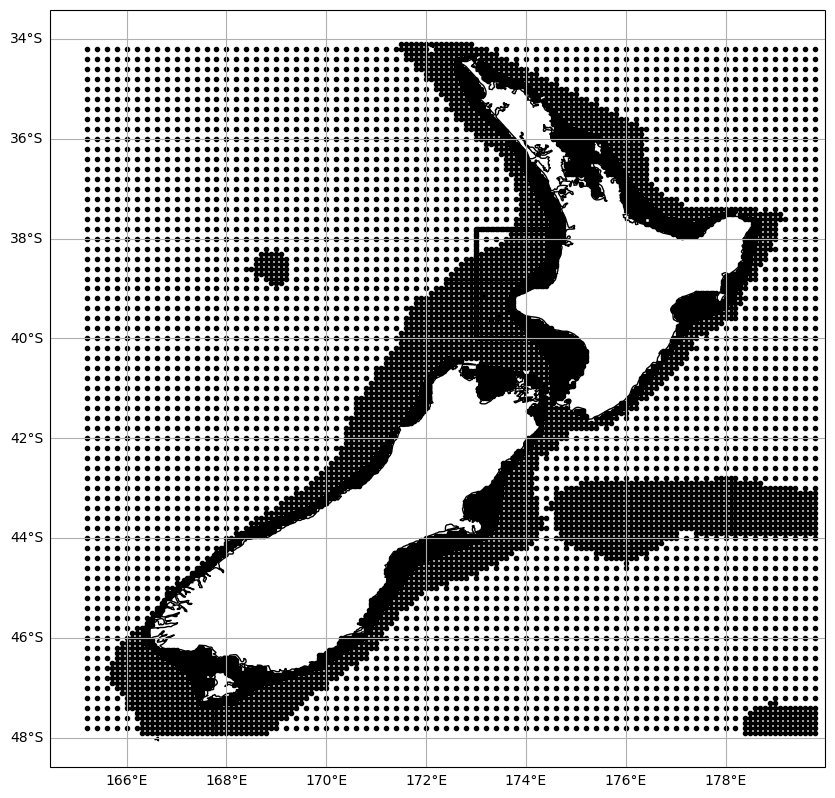

In [8]:
projection = transform = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=projection))

ax.plot(lon, lat, ".k", transform=transform)
ax.coastlines(resolution="10m")
gl = ax.gridlines(draw_labels=["left", "bottom"])

### Query spectra timeseries

Load timeseries for one year on the West and East coasts around Auckland to compare

In [9]:
query = {
    "datasource": "oceanum_wave_nz_era5_v1_spec",
    "timefilter": {"times": ["2015-01-01T00:00:00", "2016-01-01T00:00:00"]},
    "geofilter": {
            "type": "feature",
            "geom": {
                "type": "Feature",
                "geometry": {
                    "type": "MultiPoint",
                    "coordinates": [
                        [174, -37],
                        [176, -36]],
                },
            },
        },
}
dset = datamesh.query(query)

# Set point names for plotting
dset["point"] = ["West Coast", "East Coast"]

### View the points

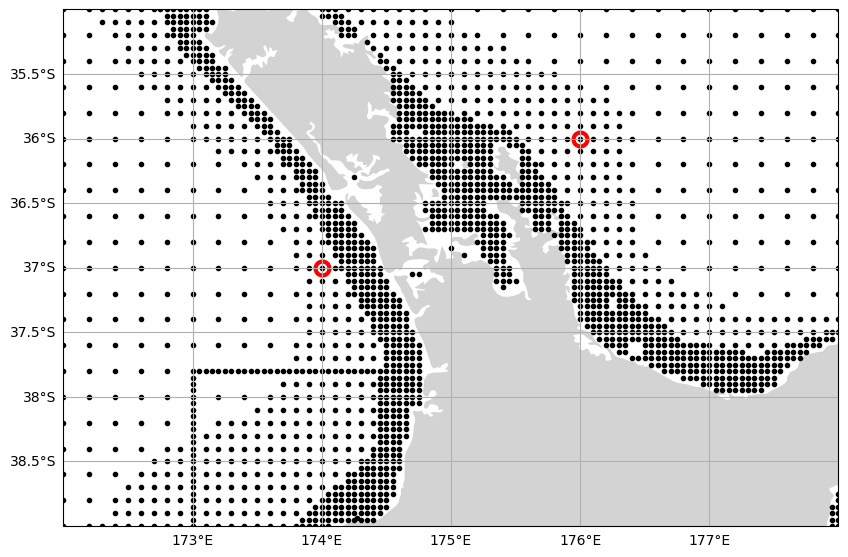

In [10]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=projection))

ax.plot(lon, lat, ".k", transform=transform)
ax.plot(dset.lon, dset.lat, "or", markersize=10, markerfacecolor="none", markeredgewidth=3, transform=transform)
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.set_extent([172, 178, -39, -35], crs=transform)
gl = ax.gridlines(draw_labels=["left", "bottom"])

## Analysis

### Yearly mean spectra on the West and East coasts

Calculate and plot the yearly mean spectra at the two coasts using xarray and wavespectra

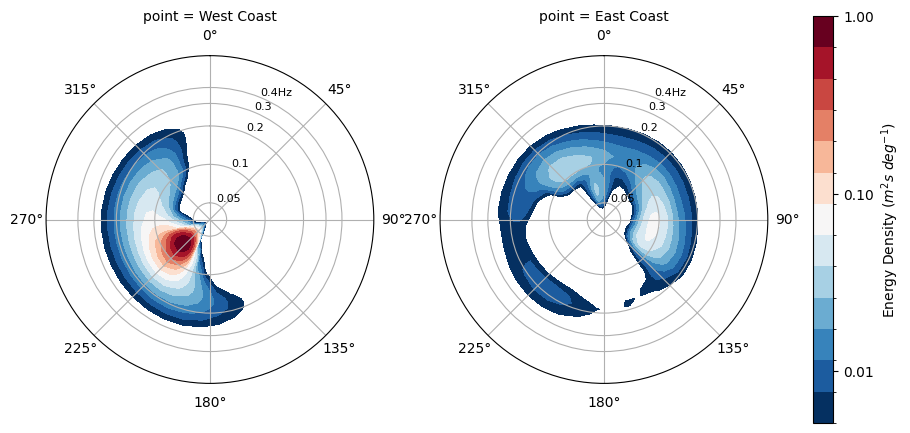

In [11]:
f = dset.mean("time").spec.plot(
    col="point",
    figsize=(10, 5),
    cbar_kwargs={"label": "Energy Density ($m^2s$ $deg^{-1}$)"},
)

### Seasonal patterns on the West Coast

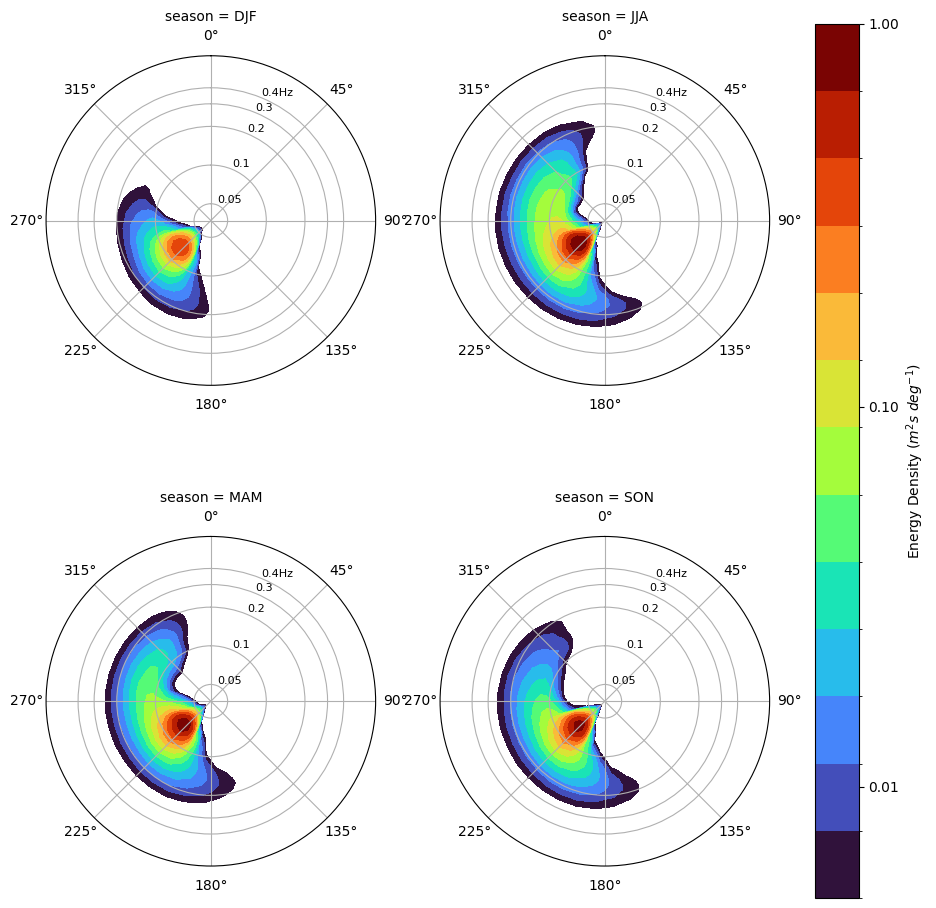

In [12]:
f = dset.isel(point=0).groupby("time.season").mean("time").spec.plot(
    col="season",
    col_wrap=2,
    figsize=(10, 10),
    cmap="turbo",
    cbar_kwargs={"label": "Energy Density ($m^2s$ $deg^{-1}$)"},
)

### Seasonal mean spectra on the East Coast

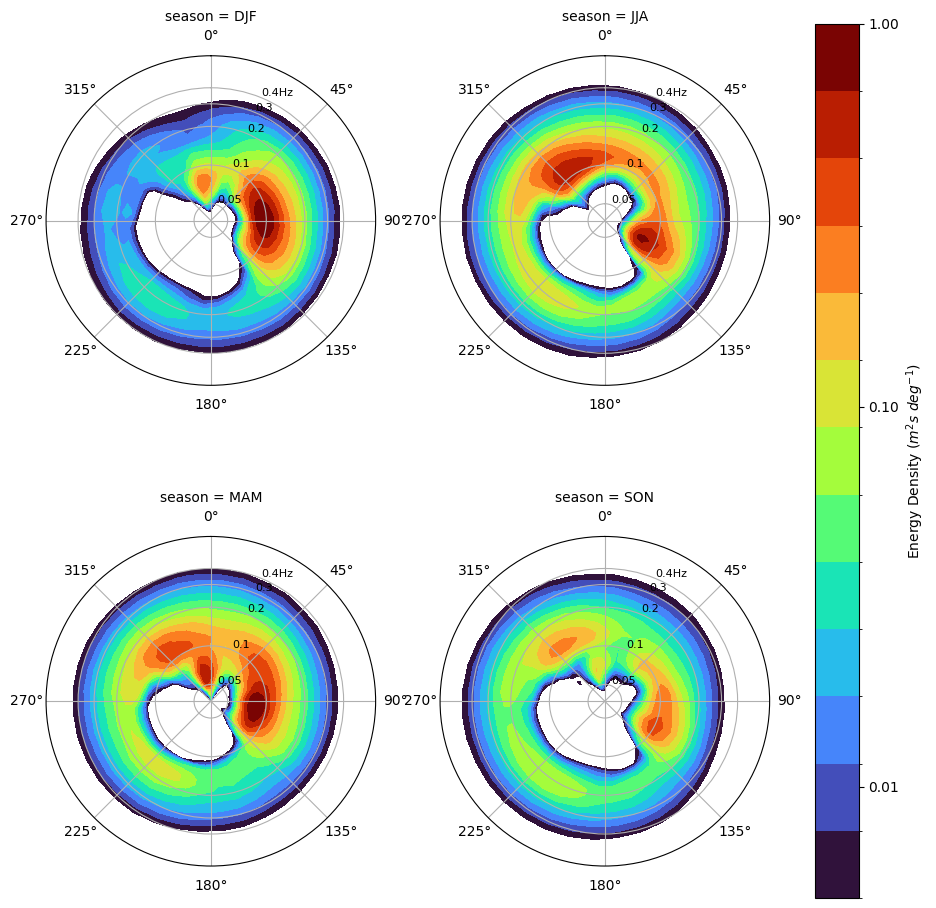

In [13]:
f = dset.isel(point=1).groupby("time.season").mean("time").spec.plot(
    col="season",
    col_wrap=2,
    figsize=(10, 10),
    cmap="turbo",
    cbar_kwargs={"label": "Energy Density ($m^2s$ $deg^{-1}$)"}
)

### Timeseries of 1D spectra

Integrate spectra over directions and plot the first month

Text(0.5, 1.0, 'East Coast')

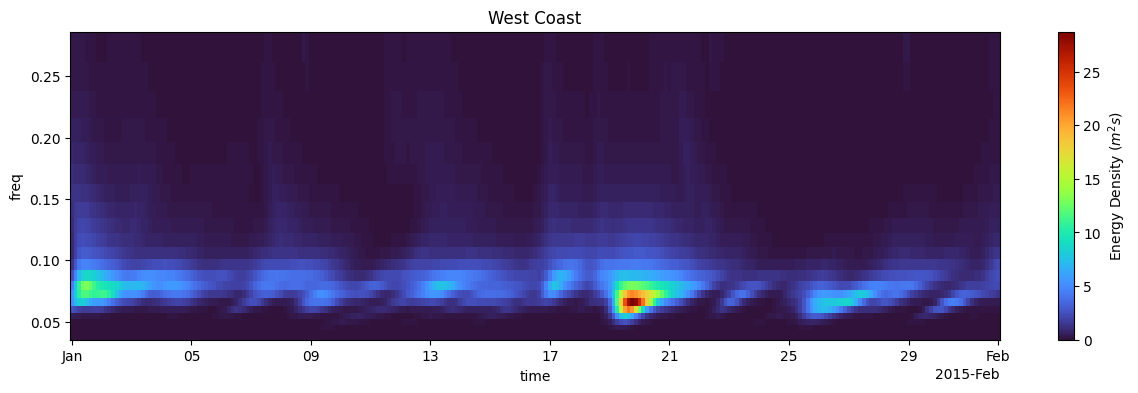

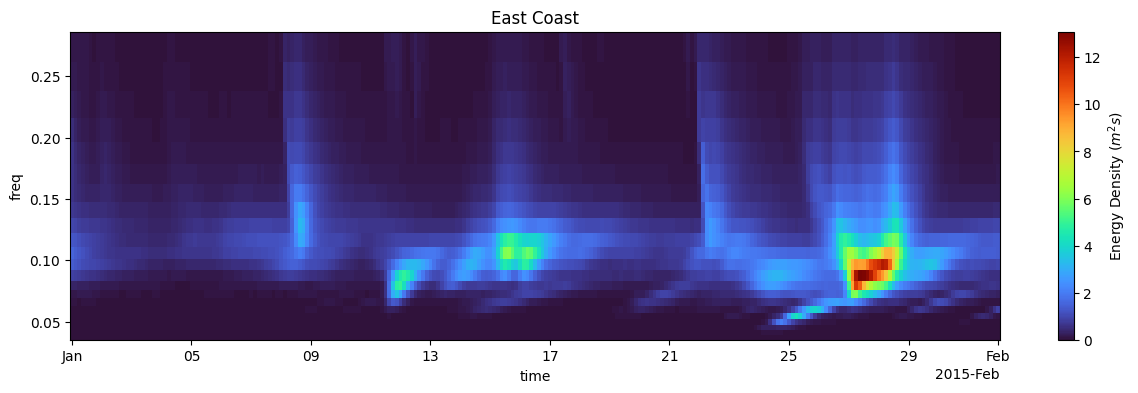

In [14]:
ds = dset.isel(point=0).spec.oned().sel(freq=slice(None, 0.3), time=slice(None, "2015-02-01 00:00"))
ds.plot(x="time", y="freq", cmap="turbo", figsize=(15, 4), cbar_kwargs={"label": "Energy Density ($m^2s$)"})
plt.title("West Coast")

ds = dset.isel(point=1).spec.oned().sel(freq=slice(None, 0.3), time=slice(None, "2015-02-01 00:00"))
ds.plot(x="time", y="freq", cmap="turbo", figsize=(15, 4), cbar_kwargs={"label": "Energy Density ($m^2s$)"})
plt.title("East Coast")

### Montly-averaged timeseries of 1D spectra

Text(0.5, 1.0, 'East Coast')

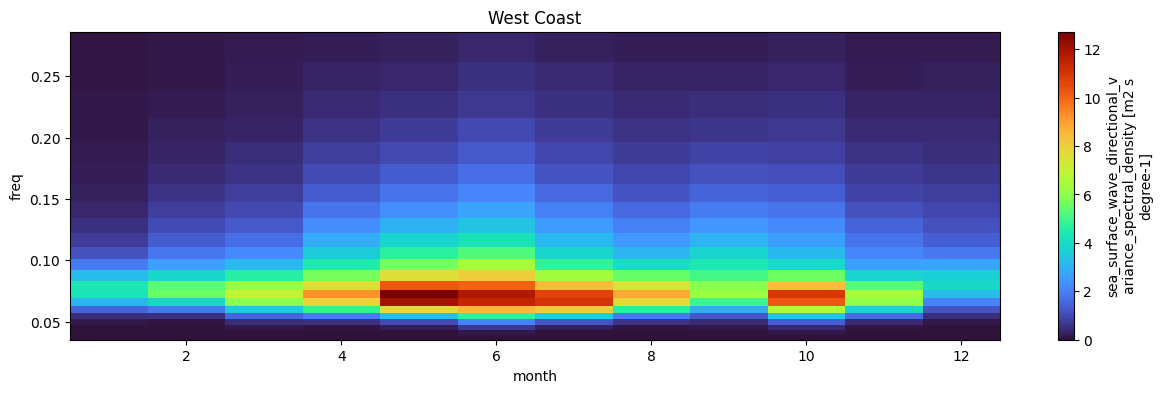

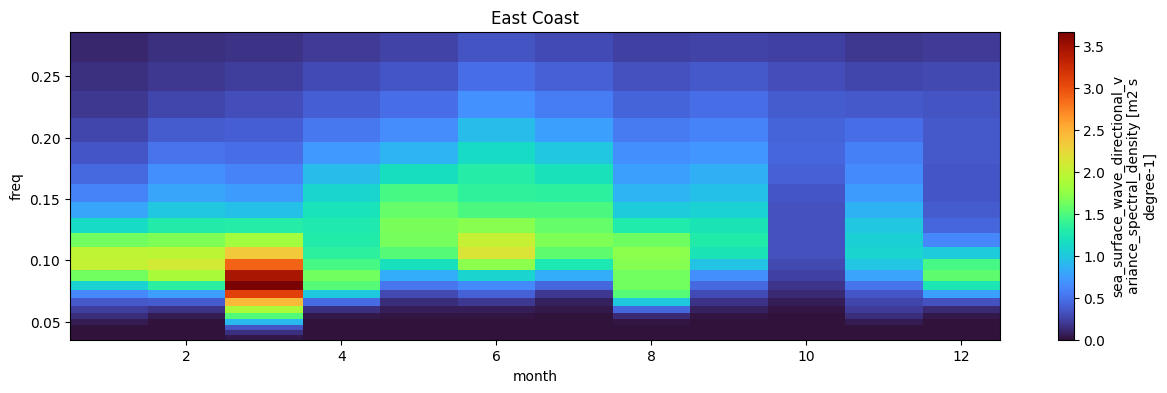

In [15]:
ds = dset.isel(point=0).spec.oned().sel(freq=slice(None, 0.3))
ds = ds.groupby("time.month").mean("time")
ds.plot(x="month", y="freq", cmap="turbo", figsize=(15, 4))
plt.title("West Coast")

ds = dset.isel(point=1).spec.oned().sel(freq=slice(None, 0.3))
ds = ds.groupby("time.month").mean("time")
ds.plot(x="month", y="freq", cmap="turbo", figsize=(15, 4))
plt.title("East Coast")

### Calculate and plot spectral statistics

In [16]:
dstats = dset.spec.stats(["hs", "hmax", "tp", "tm01", "tm02", "dpm", "dm"])
dstats

<xarray.Dataset> Size: 210kB
Dimensions:      (point: 2, time: 2921)
Coordinates:
    lat          (point) float32 8B dask.array<chunksize=(2,), meta=np.ndarray>
    lon          (point) float32 8B dask.array<chunksize=(2,), meta=np.ndarray>
    site         (point) int64 16B dask.array<chunksize=(2,), meta=np.ndarray>
  * time         (time) datetime64[ns] 23kB 2015-01-01 ... 2016-01-01
    spatial_ref  int64 8B 0
  * point        (point) <U10 80B 'West Coast' 'East Coast'
Data variables:
    hs           (time, point) float32 23kB 2.226 1.475 2.574 ... 2.639 3.719
    hmax         (time, point) float64 47kB 4.291 2.869 4.928 ... 5.114 7.176
    tp           (time, point) float32 23kB dask.array<chunksize=(2921, 2), meta=np.ndarray>
    tm01         (time, point) float32 23kB 7.508 6.147 8.213 ... 7.046 6.942
    tm02         (time, point) float32 23kB 6.408 5.596 7.073 ... 5.904 6.312
    dpm          (time, point) float32 23kB dask.array<chunksize=(2921, 2), meta=np.ndarray>
    dm           (time, point) float32 23kB 237.7 55.16 237.1 ... 226.6 41.93
Attributes:
    standard_name:  sea_surface_wave_significant_height
    units:          m

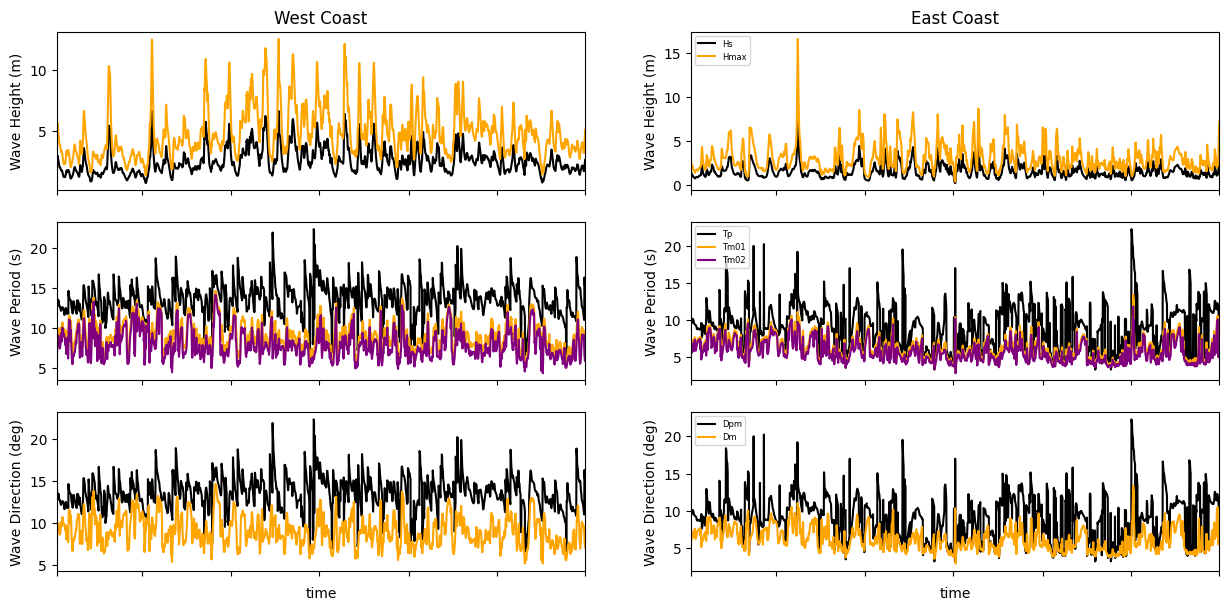

In [17]:
fig, axs = plt.subplots(3, 2, figsize=(15, 7))

for ind in range(2):
    ds = dstats.isel(point=ind)
    
    # Wave height
    ax = axs[0][ind]
    ds.hs.plot(ax=ax, color="black", label="Hs")
    ds.hmax.plot(ax=ax, color="orange", label="Hmax")
    ax.set_ylabel("Wave Height (m)")
    ax.set_xlabel("")
    
    # Wave period
    ax = axs[1][ind]
    ds.tp.plot(ax=ax, color="black", label="Tp")
    ds.tm01.plot(ax=ax, color="orange", label="Tm01")
    ds.tm02.plot(ax=ax, color="purple", label="Tm02")
    ax.set_ylabel("Wave Period (s)")
    ax.set_xlabel("")
    
    # Wave direction
    ax = axs[2][ind]
    ds.tp.plot(ax=ax, color="black", label="Dpm")
    ds.tm01.plot(ax=ax, color="orange", label="Dm")
    ax.set_ylabel("Wave Direction (deg)")


for irow, ax in enumerate(axs.flat):
    ax.set_xlim(ds.time.to_index()[[0, -1]])
    ax.grid()
    if ind in [0, 3]:
        ax.set_title(str(dstats.point.values[ind]))
    else:
        ax.set_title("")
    if ind != 2:
        ax.set_xticklabels([])

for irow, axes in enumerate(axs):
    for icol, ax in enumerate(axes):
        if icol == 1:
            ax.legend(loc=2, fontsize=6)
        ax.set_xlim(ds.time.to_index()[[0, -1]])
        ax.grid()
        if irow == 0:
            ax.set_title(str(dstats.point.values[icol]))
        else:
            ax.set_title("")
        if irow != 2:
            ax.set_xticklabels([])